# Inflation Forecasting

In [9]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import tensorflow as tf

In [10]:
# import data
df = pd.read_csv('./inflasi-indo.csv')
df

,Unnamed: 0,date,inflation-rate
0,0,2003-01-01,2.86
1,1,2003-02-01,2.56
2,2,2003-03-01,2.28
3,3,2003-04-01,3.27
4,4,2003-05-01,3.08
...,...,...,...
246,246,2023-07-01,7.15
247,247,2023-08-01,7.62
248,248,2023-09-01,7.17
249,249,2023-10-01,7.60


In [11]:
# take inflation-rate column to new dataframe
df_inf = df[['inflation-rate']]
# swap column vertically
df_inf = df_inf[::-1].reset_index(drop=True)
df_inf

,inflation-rate
0,8.68
1,7.60
2,7.17
3,7.62
4,7.15
...,...
246,3.08
247,3.27
248,2.28
249,2.56


In [12]:
# combine 2 variable
df['inflation-rate'] = df_inf
df

,Unnamed: 0,date,inflation-rate
0,0,2003-01-01,8.68
1,1,2003-02-01,7.60
2,2,2003-03-01,7.17
3,3,2003-04-01,7.62
4,4,2003-05-01,7.15
...,...,...,...
246,246,2023-07-01,3.08
247,247,2023-08-01,3.27
248,248,2023-09-01,2.28
249,249,2023-10-01,2.56


In [13]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

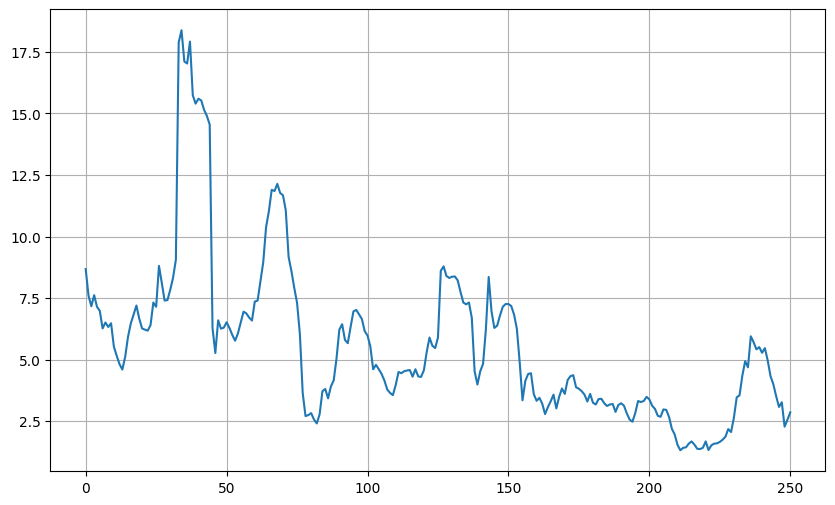

In [14]:
time_step = []
inflation = []

# append data to array
for i in range(len(df)):
    time_step.append(i)
    inflation.append(df['inflation-rate'][i])

time = np.array(time_step)
series = np.array(inflation)
# plt.figure(figsize=(10, 6))
plot_series(time, series)

In [15]:
# Define the split time
split_time = 225

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  Creates a windowed dataset out of a time series

  Args:
    series (array of int) - contains the time series
    window_size (int) - the size of the window
    batch_size (int) - the size of the batch
    shuffle_buffer (int) - the size of the shuffle buffer

  Returns:
    dataset - a windowed dataset
  """

  # Create a dataset from the series
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  # Flatten the dataset
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Shuffle the dataset
  dataset = dataset.shuffle(shuffle_buffer)

  # Map the dataset so that it contains the window and the label
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Batch the dataset
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [17]:
# parameters for the windowed dataset
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Create the windowed dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [19]:
init_weight = model.get_weights()
# print(init_weight)

In [20]:
epochs = 100
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
# optimizer = tf.keras.optimizers.Adam(lr=1e-8)
# optimizer = tf.keras.optimizers.RMSprop(lr=1e-8, rho=0.9, epsilon=1e-08, decay=0.0)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=epochs, callbacks=[lr_schedule])

Epoch 1/65


7/7 [==============================] - 6s 49ms/step - loss: 19.2506 - lr: 1.0000e-08
Epoch 2/65
7/7 [==============================] - 0s 33ms/step - loss: 18.7017 - lr: 1.1220e-08
Epoch 3/65
7/7 [==============================] - 0s 25ms/step - loss: 17.8314 - lr: 1.2589e-08
Epoch 4/65
7/7 [==============================] - 0s 27ms/step - loss: 16.7925 - lr: 1.4125e-08
Epoch 5/65
7/7 [==============================] - 0s 27ms/step - loss: 15.6488 - lr: 1.5849e-08
Epoch 6/65
7/7 [==============================] - 0s 27ms/step - loss: 14.4167 - lr: 1.7783e-08
Epoch 7/65
7/7 [==============================] - 0s 29ms/step - loss: 13.0805 - lr: 1.9953e-08
Epoch 8/65
7/7 [==============================] - 0s 27ms/step - loss: 11.6555 - lr: 2.2387e-08
Epoch 9/65
7/7 [==============================] - 0s 29ms/step - loss: 10.2227 - lr: 2.5119e-08
Epoch 10/65
7/7 [==============================] - 0s 26ms/step - loss: 8.6895 - lr: 2.8184e-08
Epoch 11/65
7/7 [==============================] - 

(1e-08, 0.001, 0.0, 100.0)

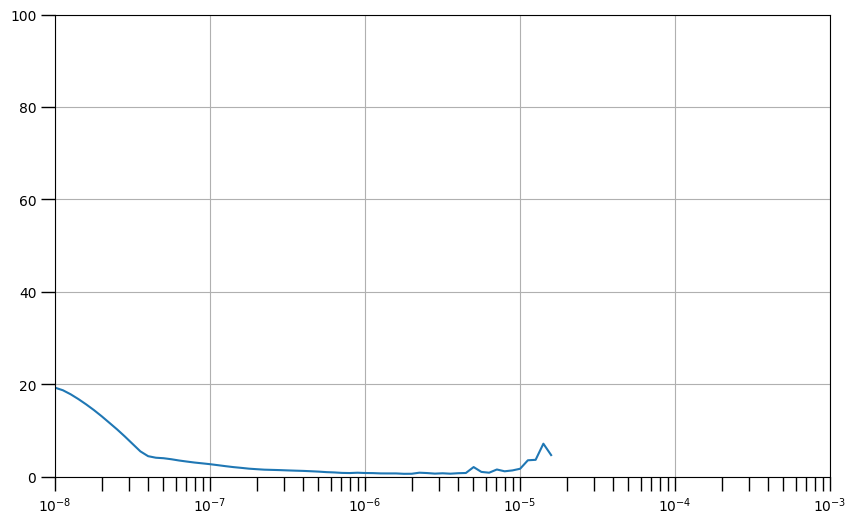

In [21]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(epochs) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [22]:
tf.keras.backend.clear_session()
model.set_weights(init_weight)

In [23]:
# Set the learning rate
learning_rate = history.history['lr'][np.argmin(history.history['loss'])]

# Set callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.1):
      print("\nMAE has reached 10%")
      self.model.stop_training = True

callbacks = myCallback()

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [24]:
history = model.fit(train_set, epochs=epochs, callbacks=[callbacks])

Epoch 1/100


7/7 [==============================] - 5s 28ms/step - loss: 13.7344 - mae: 14.2344
Epoch 2/100
7/7 [==============================] - 0s 23ms/step - loss: 6.6321 - mae: 7.1171
Epoch 3/100
7/7 [==============================] - 0s 24ms/step - loss: 6.1473 - mae: 6.6340
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 4.1938 - mae: 4.6670
Epoch 5/100
7/7 [==============================] - 0s 27ms/step - loss: 3.5167 - mae: 4.0028
Epoch 6/100
7/7 [==============================] - 0s 27ms/step - loss: 2.2283 - mae: 2.6925
Epoch 7/100
7/7 [==============================] - 0s 26ms/step - loss: 1.7158 - mae: 2.1714
Epoch 8/100
7/7 [==============================] - 0s 29ms/step - loss: 1.3148 - mae: 1.7455
Epoch 9/100
7/7 [==============================] - 0s 28ms/step - loss: 1.0656 - mae: 1.4819
Epoch 10/100
7/7 [==============================] - 0s 29ms/step - loss: 0.9739 - mae: 1.3890
Epoch 11/100
7/7 [==============================] - 0s 28ms/step - loss: 0.9691

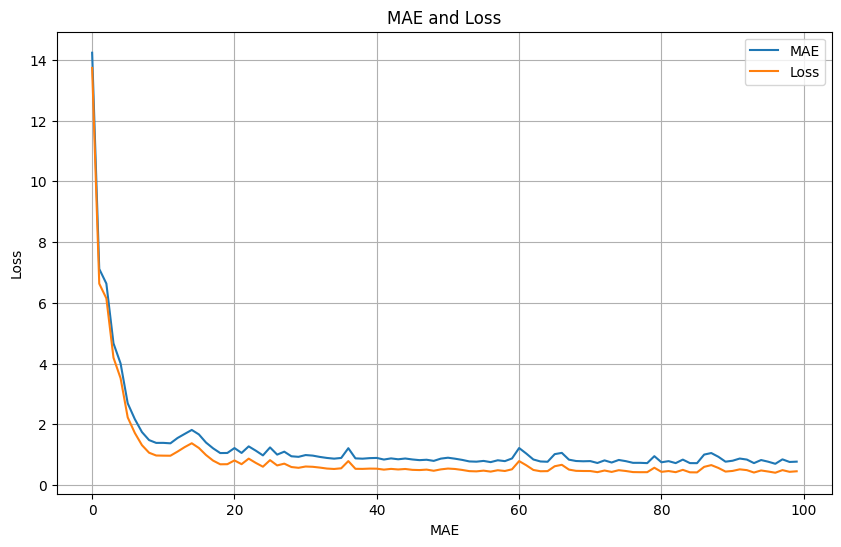

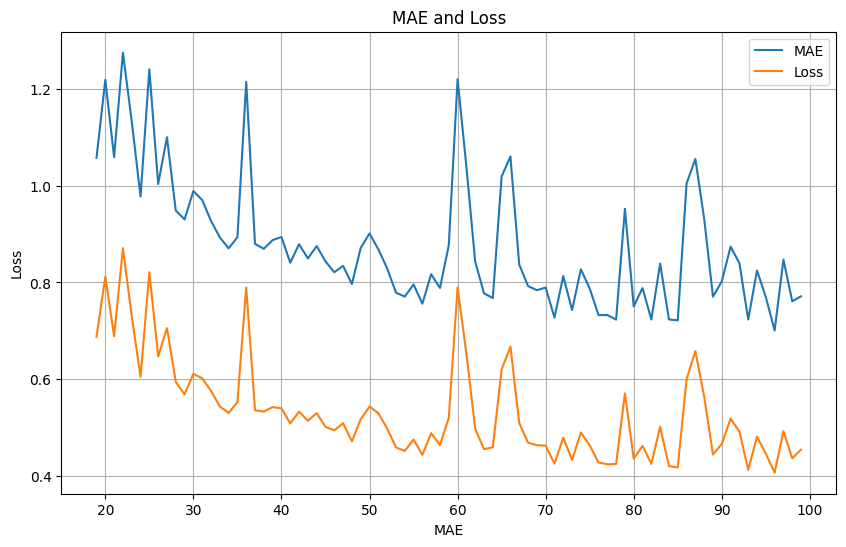

In [25]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Model Prediction

In [26]:
def model_forecast(model, series, window_size, batch_size):
  """
  Forecasts the time series using the model

  Args:
    model - the model to use for forecasting
    series (array of int) - the time series
    window_size (int) - the window size

  Returns:
    forecast - the forecasted values
  """

  # Create a dataset from the series
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the dataset
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)

  # Flatten the dataset
  dataset = dataset.flat_map(lambda window: window.batch(window_size))

  # Batch the dataset
  dataset = dataset.batch(32).prefetch(1)

  # Forecast the values
  forecast = model.predict(dataset)

  return forecast

1/1 [==============================] - 0s 77ms/step


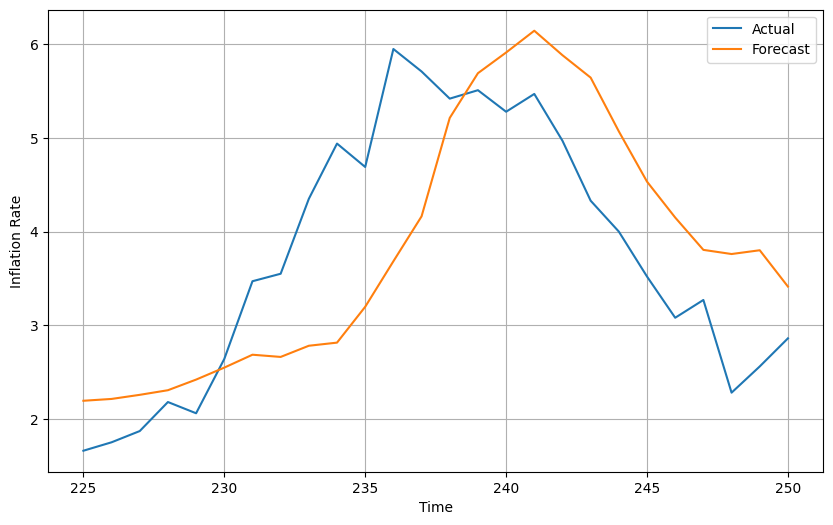

In [32]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results and show actual values vs predicted values
plot_series(time_valid, (x_valid, results), xlabel="Time", ylabel="Inflation Rate", legend=["Actual", "Forecast"])


In [31]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.904733


In [29]:
# export model
model.save('model.h5')